In [1]:
import re, time, warnings, os, sys, copy
from typing import Union, Dict
import gzip, pickle

import numpy as np
import pandas as pd
import gzip, pickle
import scipy, sklearn, mne

import auxiliary as aux
import data, rsa
sys.path.append('../spaces/')
import embeddings as emb
import pubplot as pub
import matplotlib.pyplot as plt

pub.styles.set()
C = pub.colours.equidistant('tab20c', k = 20)

In [2]:
import matplotlib

def plot_human(ax):
    '''
    '''
    
    # load pre-rendered data
    with open(f'./figures/resources/head.npy', 'rb') as f: head = np.load(f)
    with open(f'./figures/resources/brain.npy', 'rb') as f: brain = np.load(f)
    
    # setup axes
    ax.axis('off')
    ax.set_xlim([1, 0])
    ax.set_ylim([0, 1])
    ax_brain = ax.inset_axes([0.175, 0.575, 0.75, 0.375]); ax_brain.axis('off')
    ax_brain.set_xlim([1, 0])
    ax_brain.set_ylim([0, 1])
    
    # plot data
    ax.fill(head[0,:], head[1,:], color = C[19], clip_on = False)
    ax.plot(head[0,:], head[1,:], color = 'black', linewidth = 0.5, clip_on = False)
    ax_brain.fill(brain[0,:], brain[1,:], color = C[18], clip_on = False)
    
    # add eye
    e0 = matplotlib.patches.Ellipse((0.825, 0.6), 0.1, 0.075, zorder = 9, color = 'white')
    ax.add_patch(e0)
    b0 = matplotlib.patches.Ellipse((0.835, 0.6), 0.02, 0.02, zorder = 10, color = 'black')
    ax.add_patch(b0)
    
    # add mouth
    t = np.linspace(0, 1.0, 100)
    mouth = np.cos(2 * np.pi * t * 0.5 + np.pi / 10)[40:]
    t = t[40:]
    ax.plot(0.845 + t * 0.075, 0.375 + 0.025 * mouth, color = 'black', linewidth = 0.5)

def plot_gear(x, y, ax, r_o = 1.0, r_i = 0.8, r_j = 0.8, r_k = 0.65):
    '''
    '''
    
    # setup angles
    theta = np.linspace(0, 2 * np.pi, 1000)
    
    # create inner and outer circle
    c_o = np.array([r_o * np.cos(theta), r_o * np.sin(theta)])
    c_i = np.array([r_i * np.cos(theta), r_i * np.sin(theta)])
    
    # create mixture
    mix = np.cos(2 * np.pi * 1.75 * theta)
    mix[mix < 0] = -1
    mix[mix > 0] = 1
    mix = rsa.signal.smoothen(mix, rsa.signal.boxcar(50), axis = 0)
    
    # blend circles
    c_m = r_j * ((1 - mix) * c_o + mix * c_i) + np.array([x, y])[:,None]
    c_i = r_k * c_i + np.array([x, y])[:,None]
    
    ax.fill(c_m[0,:], c_m[1,:], color = C[18], clip_on = False)
    ax.fill(c_i[0,:], c_i[1,:], color = C[19], clip_on = False)

def plot_robot(ax):
    '''
    '''
    
    # load pre-rendered data
    with open(f'./figures/resources/robot.npy', 'rb') as f: robot = np.load(f)
    
    # setup axes
    ax.axis('off')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax_brain = ax.inset_axes([0.425, 0.325, 0.45, 0.45]); ax_brain.axis('off')
    ax_brain.set_xlim([-1, 1])
    ax_brain.set_ylim([-1, 1])
    
    # plot data
    ax.fill(robot[0,:], robot[1,:], color = C[19], clip_on = False)
    ax.plot(robot[0,:], robot[1,:], linewidth = 0.5, color = 'black', clip_on = False)
    
    plot_gear(-0.1, -0.15, ax_brain, r_o = 0.5, r_i = 0.35, r_k = 0.5)
    plot_gear(0.7, 0.65, ax_brain, r_o = 0.5, r_i = 0.35, r_k = 0.5)
    plot_gear(0.8, -0.8, ax_brain, r_o = 0.5, r_i = 0.35, r_k = 0.5)
    
    # add eye
    e0 = matplotlib.patches.Rectangle((0.1, 0.6), 0.1, 0.1, color = 'white')
    ax.add_patch(e0)
    b0 = matplotlib.patches.Rectangle((0.123, 0.633), 0.03, 0.03, color = 'black')
    ax.add_patch(b0)
    
    # add mouth
    m0 = matplotlib.patches.Rectangle((0.0, 0.4), 0.2, 0.1, color = 'white')
    ax.add_patch(m0)
    ax.plot([0.0, 0.2], [0.45, 0.45], color = 'black', linewidth = 1)

def plot_bracket(x, y, ax, h = 0.165, w = 0.005):
    '''
    '''
    
    ax.plot([x, x], [y, y + h], color = 'black', linewidth = 0.5, clip_on = False)
    ax.plot([x, x + w], [y, y], color = 'black', linewidth = 0.5, clip_on = False)
    ax.plot([x, x + w], [y + h, y + h], color = 'black', linewidth = 0.5, clip_on = False)

In [3]:
from subject_rerp_mt1 import load_eeg

# load sample eeg data
sub = data.Subjects['0002']
sid, pid = sub.sid, sub.pid
eeg, info = load_eeg(f'./data/preprocessed/eeg/sub{sid}/rsa-MT1-epo.fif', fs = 200)
dir_out = f'./data/processed/eeg/sub{sid}/'

# load sample behaviour
df = pd.read_csv(f'./data/raw/beh/sub{sid}/{pid}.csv')
beh = df.loc[(df.type == data.defs.TRIAL_MT_MAIN) | (df.type == data.defs.TRIAL_MT_CONTROL) | (df.type == data.defs.TRIAL_MT_PRACTICE)].reset_index(drop = True)

with gzip.open(f'{dir_out}rec-data.pkl.gz', 'rb') as f:
    (_, _, labels, _, _, _, _, _, _, _, _) = pickle.load(f)

# load invariant
with gzip.open(f'./data/results/rerp-mt1-k5-z0-s0-b0-inv-llm5.pkl.gz', 'rb') as f:
    r_inv, os_inv, ct_inv = pickle.load(f)

# load specific
with gzip.open(f'./data/results/rerp-mt1-k5-z0-s0-b0-spc-llm5.pkl.gz', 'rb') as f:
    r_spc, os_spc, ct_spc = pickle.load(f)

# load coefficients for spc
with gzip.open(f'./data/results/rerp-mt1-ko-n2-call-k5-z0-s0-b0-spc-llm5.pkl.gz', 'rb') as f:
    R2, clusters = pickle.load(f)

/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_40616/3653734613.py:296: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)
/Users/fabianschneider/Desktop/university/PhD/fabian_semantic_priors.nosync/analyses/exp4_eeg/../../semantic_spaces/pubplot/cosmetics.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  if tight_layout: plt.tight_layout()


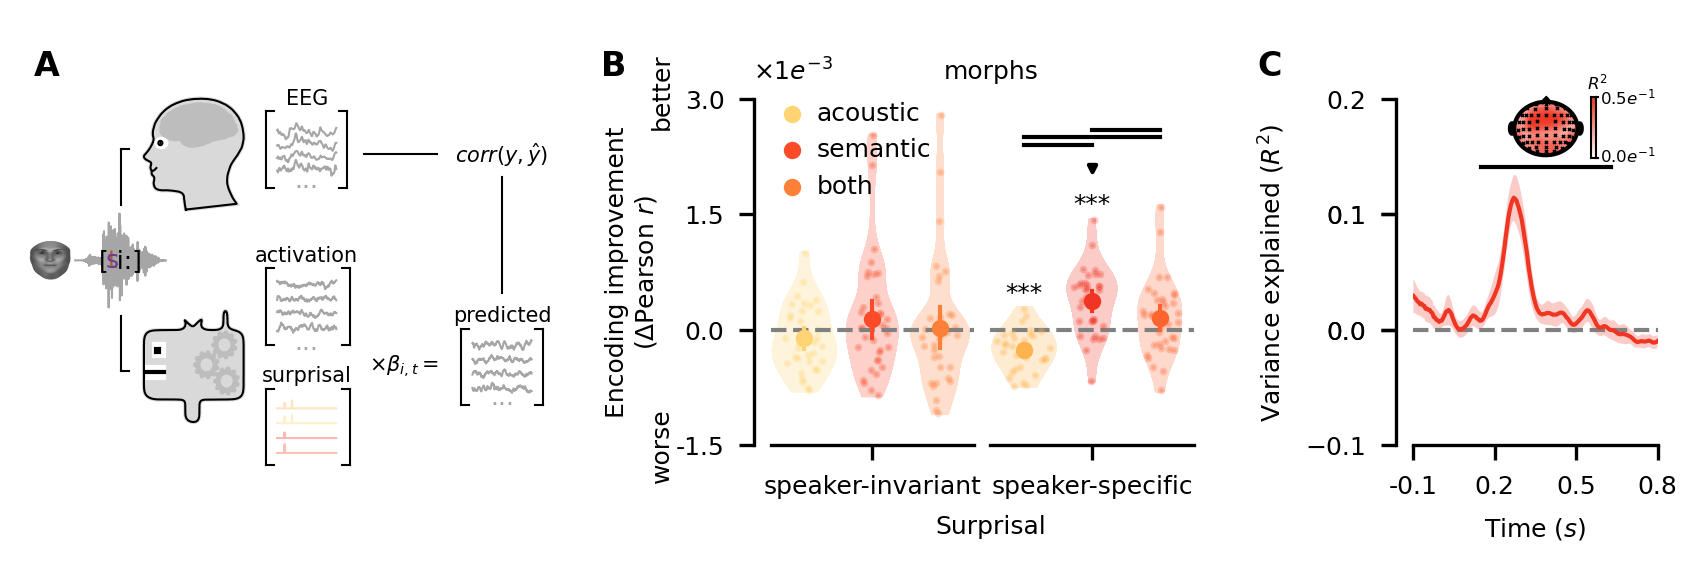

In [4]:
import seaborn as sns

C_s = pub.colours.equidistant('Paired', k = 12)
C = pub.colours.equidistant('tab20c', k = 20)

context_labels = dict(outdoor = 'nature', essen = 'food', fashion = 'fashion',
                      politik = 'politics', unterhaltung = 'arts', technik = 'tech')
order = np.array(['outdoor', 'essen', 'fashion', 'politik', 'unterhaltung', 'technik'])

colours = dict(outdoor = C_s[9], essen = C_s[11], fashion = C_s[5], 
               politik = C_s[7], unterhaltung = C_s[1], technik = C_s[3])

trial = 'See-Tee_1-1_12ch_0.50_r1_cs'
trial_a = 'See-Tee_T1'
trial_b = 'See-Tee_D1'

indx = np.where(labels == trial)[0]
TRIAL, OTHER = indx

import matplotlib
C1 = pub.colours.equidistant('YlOrRd', k = 20)
cols_inv = [C1[5], C1[12], C1[10]]
cols_spc = [C1[7], C1[13], C1[11]]
cols_bot = [C1[9], C1[14], C1[12]]

fig, ax = pub.figure(figsize = (7.0, 2.0))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

'''
add stimulus
'''

# add sound
ax_sound = ax.inset_axes([0.025, 0.38, 0.06125, 0.24]); ax_sound.axis('off')
ax_sound.set_ylim([-1, 1])
from scipy.io import wavfile
_, morph = wavfile.read('./data/raw/audio/morphed/See-Tee_1-1_12ch_0.50_r1_cs.wav')
morph = morph.astype(float)
morph /= np.abs(morph).max()
ax_sound.plot(0.85 * morph, linewidth = 0.5, color = 'black', alpha = 0.35)
ax_sound.annotate('[ i:]', xy = (morph.shape[0] / 2, 0), xytext = (morph.shape[0] / 2, 0), ha = 'center', va = 'center')
ax_sound.annotate(' t   ', color = colours['essen'], xy = (morph.shape[0] / 2, 0), xytext = (morph.shape[0] / 2, 0), ha = 'center', va = 'center')
ax_sound.annotate(' s   ', color = colours['outdoor'], xy = (morph.shape[0] / 2, 0), xytext = (morph.shape[0] / 2, 0), ha = 'center', va = 'center')

# add speaker
ax_spkr = ax.inset_axes([0.0, 0.46, 0.025, 0.08]); ax_spkr.axis('off')
pub.graphs.procedure([dict(T = 'image-only', stimulus = './data/raw/misc/faces/face7_piercing2.png', delay = '', duration = r'', style = dict(scatter = dict(alpha = 0.01)))], ax = ax_spkr)

# add connections
ax_sound.plot([morph.shape[0] / 2, morph.shape[0] / 2], [1.0, 2.0], linewidth = 0.5, color = 'black', clip_on = False)
ax_sound.plot([morph.shape[0] / 2, morph.shape[0] / 1.7], [2.0, 2.0], linewidth = 0.5, color = 'black', clip_on = False)
ax_sound.plot([morph.shape[0] / 2, morph.shape[0] / 2], [-1.0, -2.0], linewidth = 0.5, color = 'black', clip_on = False)
ax_sound.plot([morph.shape[0] / 2, morph.shape[0] / 1.7], [-2.0, -2.0], linewidth = 0.5, color = 'black', clip_on = False)

'''
generate human side of the plot
'''

# add human
ax_human = ax.inset_axes([0.07, 0.61, 0.06125, 0.24])
plot_human(ax_human)

# add eeg
ax_eeg = ax.inset_axes([0.15, 0.6775, 0.04, 0.125]); ax_eeg.axis('off')
absmax = np.abs(eeg[TRIAL,:,100:300]).max()

for i in range(4): ax_eeg.plot(eeg[TRIAL,i,100:300] + i * absmax, color = 'black', alpha = 0.35, linewidth = 0.5)
ax_eeg.annotate('...', alpha = 0.35, xy = (100, -1.0 * absmax), xytext = (100, -1.0 * absmax), ha = 'center', va = 'center', annotation_clip = False)

plot_bracket(0.145, 0.6575, ax, h = 0.165, w = 0.005)
plot_bracket(0.195, 0.6575, ax, h = 0.165, w = -0.005)
ax.annotate('EEG', xy = (0.17, 0.85), xytext = (0.17, 0.85), fontsize = 5, ha = 'center', va = 'center')

'''
generate robot side of plot
'''

# add robot
ax_robot = ax.inset_axes([0.07, 0.15, 0.06125, 0.24])
plot_robot(ax_robot)

# create masks
mask_pho = np.zeros((200,))
mask_wrd = np.zeros((200,))

mask_pho[[25,50]] = 1.0
mask_wrd[25] = 1.0

# add activations
acts = np.random.normal(loc = 0, scale = 0.25, size = (200, 4))
actsmax = 0.75 * np.abs(acts).max()
acts = rsa.signal.smoothen(acts, rsa.signal.boxcar(10), axis = 0)
acts += np.arange(0, acts.shape[1] * actsmax, actsmax)

ax_act = ax.inset_axes([0.15, 0.3375, 0.04, 0.125]); ax_act.axis('off')
ax_act.plot(acts, color = 'black', linewidth = 0.5, alpha = 0.35)
ax_act.annotate('...', alpha = 0.35, xy = (100, -1.0 * actsmax), xytext = (100, -1.0 * actsmax), ha = 'center', va = 'center', annotation_clip = False)

# add brackets (activations)
plot_bracket(0.145, 0.3175, ax, h = 0.165, w = 0.005)
plot_bracket(0.1965, 0.3175, ax, h = 0.165, w = -0.005)
ax.annotate('activation', xy = (0.17, 0.51), xytext = (0.17, 0.51), fontsize = 5, ha = 'center', va = 'center')

# add surprisal
s_cols = [cols_inv[1], cols_spc[1], cols_inv[0], cols_spc[0]]
surp = np.random.uniform(low = 0.2, high = 0.75, size = (200, 4))
surpmax = 1.5 * np.abs(surp).max()
surp[:,[0, 1]] = surp[:,[0, 1]] * mask_wrd[:,None]
surp[:,[2, 3]] = surp[:,[2, 3]] * mask_pho[:,None]
surp += np.arange(0, surp.shape[1] * surpmax, surpmax)

ax_surp = ax.inset_axes([0.15, 0.0775, 0.04, 0.125]); ax_surp.axis('off')
for i in range(4): ax_surp.plot(surp[:,i], linewidth = 0.5, alpha = 0.35, color = s_cols[i])

# add brackets (surprisal)
plot_bracket(0.145, 0.0575, ax, h = 0.165, w = 0.005)
plot_bracket(0.1965, 0.0575, ax, h = 0.165, w = -0.005)
ax.annotate('surprisal', xy = (0.17, 0.25), xytext = (0.17, 0.25), fontsize = 5, ha = 'center', va = 'center')

# add equation
ax.annotate(r'$\times\beta_{i,t} = $', xy = (0.23, 0.15), xytext = (0.23, 0.27), ha = 'center', va = 'center', fontsize = 5)

# add reconstruction
ax_rec = ax.inset_axes([0.27, 0.2075, 0.04, 0.125]); ax_rec.axis('off')
noise = np.random.normal(loc = 0, scale = 3 * eeg.std(), size = eeg.shape)
noise = rsa.signal.smoothen(noise, rsa.signal.boxcar(10), axis = 2)
rec = eeg[TRIAL,:,100:300] + noise[TRIAL,:,100:300]
recmax = 1.5 * np.abs(rec).max()

for i in range(4):
    ax_rec.plot(rec[i,:] + i * recmax, color = 'black', linewidth = 0.5, alpha = 0.35)
ax_rec.annotate('...', alpha = 0.35, xy = (100, -0.66 * recmax), xytext = (100, -0.66 * recmax), ha = 'center', va = 'center', annotation_clip = False)
plot_bracket(0.265, 0.1875, ax, h = 0.165, w = 0.005)
plot_bracket(0.315, 0.1875, ax, h = 0.165, w = -0.005)
ax.annotate('predicted', xy = (0.29, 0.38), xytext = (0.29, 0.38), fontsize = 5, ha = 'center', va = 'center')

'''
connect human/robot
'''

ax.annotate(r'$corr(y, \hat{y})$', xy = (0, 0), xytext = (0.29, 0.73), ha = 'center', va = 'center', fontsize = 5)
ax.plot([0.29, 0.29], [0.43, 0.68], color = 'black', linewidth = 0.5)
ax.plot([0.205, 0.25], [0.73, 0.73], color = 'black', linewidth = 0.5)

'''
add encoder results
'''

ax_enc0 = ax.inset_axes([0.455, 0.1, 0.125, 0.75])
ax_enc1 = ax.inset_axes([0.59, 0.1, 0.125, 0.75])

diff_inv = (r_inv[:,1:] - r_inv[:,0,None])
diff_spc = (r_spc[:,1:] - r_spc[:,0,None])

bw = pub.dist._bandwidth_botev(np.array([diff_inv, diff_spc]).flatten())

ax_enc1.plot([-0.5, 2.5], [0, 0], color = 'gray', linestyle = '--')
pub.dist.violins(diff_inv.T, offset_x = 0, colours = cols_inv,
                 kernel_bandwidth = bw, scatter_dep = False, 
                 jitter = True, jitter_max = 1.75 * bw, labels = ['acoustic', 'semantic', 'both'],
                 ax = ax_enc0)

ax_enc0.plot([-0.5, 2.5], [0, 0], color = 'gray', linestyle = '--')
pub.dist.violins(diff_spc.T, offset_x = 0, colours = cols_spc,
                 kernel_bandwidth = bw, scatter_dep = False, 
                 jitter = True, jitter_max = 1.75 * bw,
                 ax = ax_enc1)

# add significance (for inv)
sigs = 2
off = 1.0e-4
maxval = np.abs(diff_inv).max()

for c_i, ct in enumerate(ct_inv):
    # grab contrast
    contrast = ct_inv[ct]
    
    # grab anchors
    i, j = ct.split(' ')[1].split('-')
    i, j = int(i), int(j)
    
    # determine sig
    p_i = contrast['p_cor']
    sig = pub.significance.__sig_from_p(p_i)
    
    if p_i > .05: continue
    
    if j == 0:
        ax_enc0.annotate(sig, xy = (i-1, diff_inv[:,i-1].max() + sigs * off), xytext = (i-1, diff_inv[:,i-1].max() + sigs * off), ha = 'center', va = 'center', annotation_clip = False)
    else:
        y_i = maxval + (sigs + 6) * off
        ax_enc0.plot([i-1, j-1], [y_i, y_i], color = 'black')
        sigs += 1

# add significance (for spc)
sigs = 2
off = 1.0e-4
maxval = np.abs(diff_spc).max()

for c_i, ct in enumerate(ct_spc):
    # grab contrast
    contrast = ct_spc[ct]
    
    # grab anchors
    i, j = ct.split(' ')[1].split('-')
    i, j = int(i), int(j)
    
    # determine sig
    p_i = contrast['p_cor']
    sig = pub.significance.__sig_from_p(p_i)
    
    if p_i > .05: continue
    
    if j == 0:
        ax_enc1.annotate(sig, xy = (i-1, diff_spc[:,i-1].max() + sigs * off), xytext = (i-1, diff_spc[:,i-1].max() + sigs * off), ha = 'center', va = 'center', annotation_clip = False)
    else:
        y_i = maxval + (sigs + 6) * off
        ax_enc1.plot([i-1, j-1], [y_i, y_i], color = 'black')
        sigs += 1

best = np.argmax(diff_spc.mean(axis = 0))
sigs = 5
ax_enc1.scatter([best], [diff_spc[:,i-1].max() + sigs * off], marker = 'v', s = 3, color = 'black')

ax_enc0.set_yticks(np.arange(-1.5e-3, 3.1e-3, 1.5e-3))
ax_enc0.set_yticklabels(['-1.5', '0.0', '1.5', '3.0'])
ax_enc0.set_ylim([-1.5e-3, 3.0e-3])
ax_enc0.set_ylabel('Encoding improvement\n' + r'($\Delta$Pearson $r$)')
ax_enc0.annotate(r'better', xy = (0, 0), xytext = (-2.1, 3.1e-3), rotation = 90, ha = 'center', va = 'center', annotation_clip = False)
ax_enc0.annotate(r'worse', xy = (0, 0), xytext = (-2.1, -1.5e-3), rotation = 90, ha = 'center', va = 'center', annotation_clip = False)


ax_enc1.set_yticks([])
ax_enc1.set_ylim([-1.5e-3, 3.0e-3])

ax_enc0.set_xticks([1], labels = ['speaker-invariant'])
ax_enc1.set_xticks([1], labels = ['speaker-specific'])

pub.cosmetics.legend(ax = ax_enc0, loc = 'upper left', borderpad = 0.0, handletextpad = 0.25, borderaxespad = 0.1)

ax_enc0.set_xlim([-0.5, 2.5])
ax_enc0.spines['left'].set_position(('data', -0.75))

ax_enc1.set_xlim([-0.5, 2.5])
ax_enc1.spines['left'].set_position(('data', -0.75))

sns.despine(ax = ax_enc0)
ax_enc1.spines[['top', 'left', 'right']].set_visible(False)

ax_enc0.annotate(r'$\times 1e^{-3}$', xy = (-0.175, 3.35e-3), xytext = (-0.175, 3.35e-3), ha = 'center', va = 'center', annotation_clip = False)
ax_enc0.annotate('Surprisal', xy = (2.75, -2e-3), xytext = (2.75, -2.55e-3), ha = 'center', va = 'center', annotation_clip = False)
ax_enc0.annotate('morphs', xy = (2.75, 3.35e-3), xytext = (2.75, 3.35e-3), ha = 'center', va = 'center', annotation_clip = False, zorder=999)

'''
add coefficient results
'''

ax_c = ax.inset_axes([0.85, 0.1, 0.15, 0.75])

cluster = clusters['ß_17'][0]
#cluster = clusters['ß_9'][0]
chs = cluster['chs_i']
tmin, tmax = cluster['tmin'], cluster['tmax']
ß = R2[:,chs,-1,:]
mu = ß.mean(axis = (0, 1))
se = rsa.stats.bootstrap_se(ß.mean(axis = 1))
lb, ub = mu - 1.96 * se, mu + 1.96 * se
t = np.arange(se.shape[0])

w = R2[:,:,-1,tmin:tmax].mean(axis = (0, 2))
mp = tmin + (tmax - tmin) / 2
mp = mp / 180
mp = mp - 0.175
ax_topo = ax_c.inset_axes([mp, 0.8, 0.35, 0.2]); ax_topo.axis('off')
from inference_rsa_rec import _plot_topo_inlay
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black', 'white', cols_spc[1]])
_plot_topo_inlay(w, info, ax = ax_topo, sensors = False, highlight = chs, cmap = cmap)

ax_col_cof = ax_c.inset_axes([mp+0.36, 0.83, 0.02, 0.175]); ax_col_cof.axis('off')
ax_col_cof.set_xlim([0, 1])
ax_col_cof.set_ylim([0, 1])
ax_col_cof.plot([0, 1], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 1], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 0], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
wmax = w.max()
ax_col_cof.annotate(fr'${np.round(wmax*10, 1)}e^{{-1}}$', fontsize = 4, xy = (1.75, 1), xytext = (1.75, 1.0), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(fr'$0.0e^{{-1}}$', fontsize = 4, xy = (1.75, 0.0), xytext = (1.75, 0.05), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(r'$R^2$', fontsize = 4, xy = (1.25, 1.25), xytext = (1.25, 1.25), ha = 'center', va = 'center', annotation_clip = False)
cb_x = np.linspace(0, 1, 5)
cb_y = np.linspace(0, 1, 5)
cb_x, cb_y = np.meshgrid(cb_x, cb_y)
ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)

ax_c.plot([0, 180], [0, 0], color = 'gray', linestyle = '--')
ax_c.plot([tmin, tmax], [1.05 * ub.max(), 1.05 * ub.max()], color = 'black')
ax_c.fill_between(t, lb, ub, edgecolor = None, facecolor = cols_spc[1], alpha = 0.25)
ax_c.plot(mu, color = cols_spc[1])
ax_c.set_ylim([np.round(3.5 * lb.min(), 1), 1.4 * ub.max()])
ax_c.set_yticks(np.round(np.linspace(3.5 * lb.min(), 1.4 * ub.max(), 6), 1))
ax_c.set_ylabel(r'Variance explained ($R^2$)') 
ax_c.set_xlabel(r'Time ($s$)')
ax_c.set_xticks(np.arange(0, 181, 60))
ax_c.set_xticklabels(np.round(np.arange(-20, 161, 60)*5e-3, 2))
sns.despine(ax = ax_c)

ax_c.set_xlim([0, 180])
ax_c.spines['left'].set_position(('data', -13))


'''
add labels
'''

pub.cosmetics.figlabels(['A'], x_offset = 0.01, y_offset = -0.08, ax = ax)
pub.cosmetics.figlabels(['B'], x_offset = -0.77, y_offset = 0.095, ax = ax_enc0)
pub.cosmetics.figlabels(['C'], x_offset = -0.59, y_offset = 0.095, ax = ax_c)

ax.axis('off')
pub.cosmetics.finish()

fig.savefig(f'./figures/png/fig3_surprisal.png', dpi = 300)
fig.savefig(f'./figures/svg/fig3_surprisal.svg')
fig.savefig(f'./figures/pdf/fig3_surprisal.pdf')